<a href="https://colab.research.google.com/github/prasanth5reddy/GANs/blob/master/DCGAN/mnist_and_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mounting Drive

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import sys
w_dir = '/content/drive/My Drive/Colab/GANs/'
sys.path.append(w_dir)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installing Libraries

In [2]:
!pip3 install torch torchvision

Importing Libraries

In [0]:
import torch
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets, utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import time

To use or not use CUDA

In [4]:
use_cuda = True
cuda = True if use_cuda and torch.cuda.is_available() else False
cuda

True

Dataset

In [0]:
def mnist_data():
  compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])])
  out_dir = w_dir + 'data'
  return datasets.MNIST(root=out_dir, download=True, train=True, transform=compose)

def fashion_mnist_data():
  compose = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5])])
  out_dir = w_dir + 'data'
  return datasets.FashionMNIST(root=out_dir, download=True, train=True, transform=compose)

mnist_data = mnist_data()
batch_size = 128
mnist_dataloader = torch.utils.data.DataLoader(mnist_data, batch_size=batch_size, shuffle=True)

fashion_mnist_data = fashion_mnist_data()
batch_size = 128
fashion_mnist_dataloader = torch.utils.data.DataLoader(fashion_mnist_data, batch_size=batch_size, shuffle=True)

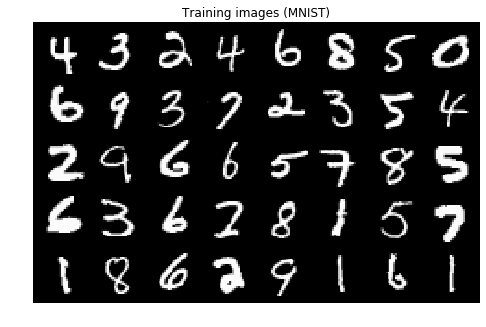

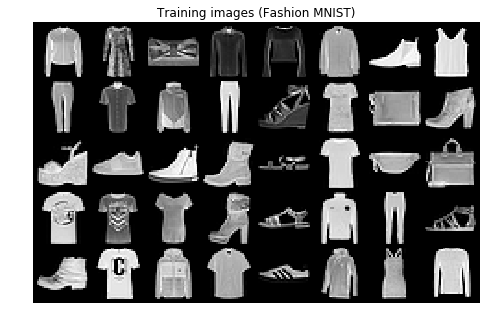

In [6]:
def show_images(imgs, fig_size, num_of_images, title):
  plt.figure(figsize=fig_size)
  plt.axis("off")
  plt.title(title)
  plt.imshow(np.transpose(vutils.make_grid(imgs.cuda()[:num_of_images], padding=2, normalize=True).cpu(),(1,2,0)))
  plt.show()

show_images(next(iter(mnist_dataloader))[0], (8, 8), 40, 'Training images (MNIST)')
show_images(next(iter(fashion_mnist_dataloader))[0], (8, 8), 40, 'Training images (Fashion MNIST)')

Weight Initialization

In [0]:
# From the DCGAN Paper, these weight initializations are given.
def weights_init(m):
  class_name = m.__class__.__name__
  if class_name.find('Conv') != -1:
    nn.init.normal_(m.weight.data, 0, 0.02)
  elif class_name.find('BatchNorm') != -1:
    nn.init.normal_(m.weight.data, 1, 0.02)
    nn.init.constant_(m.bias.data, 0)

Networks

In [0]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator, self).__init__()
    nz = 100
    ngf = 28
    nc = 1
    self.main = nn.Sequential(
        # input Z to convolution
        nn.ConvTranspose2d(nz, ngf * 8, kernel_size=4, stride=1, padding=0, bias=False),
        nn.BatchNorm2d(ngf * 8),
        nn.ReLU(True),
        # state size. (ngf*8) x 4 x 4
        nn.ConvTranspose2d(ngf * 8, ngf * 4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf * 4),
        nn.ReLU(True),
        # state size. (ngf*4) x 8 x 8
        nn.ConvTranspose2d(ngf * 4, ngf * 2, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ngf * 2),
        nn.ReLU(True),
        # state size. (ngf*2) x 16 x 16
        # Here one layer is removed and padding is made 3 to adjust for fashion mnist 28x28 images
        nn.ConvTranspose2d(ngf * 2, nc, kernel_size=4, stride=2, padding=3, bias=False),
        nn.Tanh()
        # state size. (nc) x 28 x 28
    )
  def forward(self, x):
    return self.main(x)
  
def noise(size):
  noise = Variable(torch.randn(size, 100, 1, 1))
  return noise.cuda() if cuda else noise

In [0]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator, self).__init__()
    nc = 1
    ndf = 28
    self.main = nn.Sequential(
        nn.Conv2d(nc, ndf * 2, kernel_size=4, stride=2, padding=3, bias=False),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*2) x 16 x 16
        nn.Conv2d(ndf * 2, ndf * 4, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ndf * 4),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*4) x 8 x 8
        nn.Conv2d(ndf * 4, ndf * 8, kernel_size=4, stride=2, padding=1, bias=False),
        nn.BatchNorm2d(ndf * 8),
        nn.LeakyReLU(0.2, inplace=True),
        # state size. (ndf*8) x 4 x 4
        nn.Conv2d(ndf * 8, 1, kernel_size=4, stride=1, padding=0, bias=False),
        nn.Sigmoid()
        # state size. 1 x 1 x 1
    )
  def forward(self, x):
    return self.main(x)

In [10]:
generator = Generator()
discriminator = Discriminator()
if cuda:
  generator.cuda()
  discriminator.cuda()

generator.apply(weights_init)
discriminator.apply(weights_init)

generator, discriminator

(Generator(
   (main): Sequential(
     (0): ConvTranspose2d(100, 224, kernel_size=(4, 4), stride=(1, 1), bias=False)
     (1): BatchNorm2d(224, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (2): ReLU(inplace)
     (3): ConvTranspose2d(224, 112, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (4): BatchNorm2d(112, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (5): ReLU(inplace)
     (6): ConvTranspose2d(112, 56, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
     (7): BatchNorm2d(56, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     (8): ReLU(inplace)
     (9): ConvTranspose2d(56, 1, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
     (10): Tanh()
   )
 ), Discriminator(
   (main): Sequential(
     (0): Conv2d(1, 56, kernel_size=(4, 4), stride=(2, 2), padding=(3, 3), bias=False)
     (1): LeakyReLU(negative_slope=0.2, inplace)
     (2): Conv2d(56, 112, kernel_size=(4, 4)

Optimizers

In [0]:
d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss = nn.BCELoss()

num_epochs = 5

Generate labels

In [0]:
def real_label(size):
  data = Variable(torch.ones(size, 1, 1, 1))
  return data.cuda() if cuda else data

def fake_label(size):
  data = Variable(torch.zeros(size, 1, 1, 1))
  return data.cuda() if cuda else data

Train functions

In [0]:
def train_discriminator(X, X_dash, net_D, loss, optim_D):
  optim_D.zero_grad()
  
  real_Y = net_D(X)
  fake_Y = net_D(X_dash)
  
  loss_D = loss(real_Y, real_label(X.size(0))) + loss(fake_Y, fake_label(X.size(0)))
  loss_D.backward()
  
  optim_D.step()
  return torch.sum(loss_D).item()

In [0]:
def train_generator(X_dash, net_D, loss, optim_G):
  optim_G.zero_grad()

  fake_Y = net_D(X_dash)
  
  loss_G = loss(fake_Y, real_label(X_dash.size(0)))
  loss_G.backward()
  
  optim_G.step()
  return torch.sum(loss_G).item()

Training

In [0]:
def train_gan(dataloader, net_G, net_D):
  list_loss_G, list_loss_D = [], []
  for epoch in range(1, num_epochs + 1):
    start = time.time()
    sum_loss_G, sum_loss_D, num_of_samples = 0, 0, 0
    for i, (X, _) in enumerate(dataloader):
      # Train Discriminator
      X = X.cuda() if cuda else X
      Z = noise(X.size(0))
      X_dash = net_G(Z)
      # Don't want to update weights of generator while training discriminator. Hence, detach()
      loss_D = train_discriminator(X, X_dash.detach(), net_D, loss, d_optimizer)
      sum_loss_D += loss_D

      # Train Generator
      loss_G = train_generator(X_dash, net_D, loss, g_optimizer)
      sum_loss_G += loss_G

      num_of_samples += batch_size

      # print(f'Epoch: [{epoch}/{num_epochs}], Batch Number: [{i + 1}/{len(dataloader)}]')
      # print(f'Discriminator Loss: {loss_D}, Generator Loss: {loss_G}')

    loss_dis, loss_gen = sum_loss_D / num_of_samples, sum_loss_G / num_of_samples 
    print(f'Epoch: [{epoch}/{num_epochs}], Run Time: {round(time.time() - start, 4)} Sec')
    print(f'Discriminator Loss: {round(loss_dis, 4)}, Generator Loss: {round(loss_gen, 4)}')
    list_loss_D.append(loss_dis)
    list_loss_G.append(loss_gen)
  
  return list_loss_G, list_loss_D

MNIST

In [16]:
loss_G, loss_D = train_gan(mnist_dataloader, generator, discriminator)

Epoch: [1/5], Run Time: 21.3738 Sec
Discriminator Loss: 0.0027, Generator Loss: 0.0282
Epoch: [2/5], Run Time: 21.6365 Sec
Discriminator Loss: 0.0037, Generator Loss: 0.0218
Epoch: [3/5], Run Time: 21.5105 Sec
Discriminator Loss: 0.0046, Generator Loss: 0.0172
Epoch: [4/5], Run Time: 21.3697 Sec
Discriminator Loss: 0.0052, Generator Loss: 0.0157
Epoch: [5/5], Run Time: 21.3799 Sec
Discriminator Loss: 0.0053, Generator Loss: 0.0153


Plot Generator vs Discriminator loss

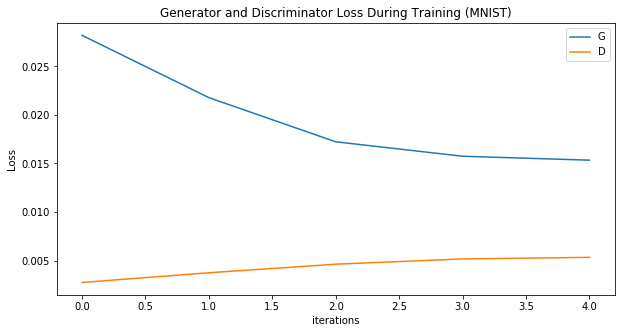

In [17]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (MNIST)")
plt.plot(loss_G,label="G")
plt.plot(loss_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Save parameters

In [0]:
torch.save(generator.state_dict(), w_dir + 'DCGAN/generator_mnist.pth')
torch.save(discriminator.state_dict(), w_dir + 'DCGAN/discriminator_mnist.pth')

Generate and display fake images

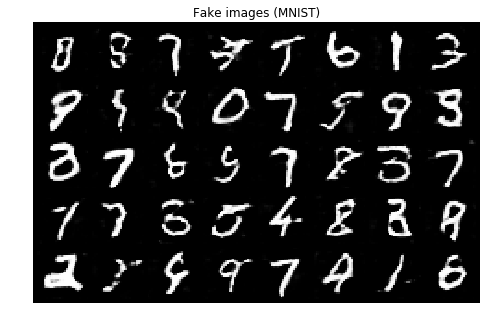

In [19]:
fake_imgs = generator(noise(128)).detach()
show_images(fake_imgs, (8, 8), 40, 'Fake images (MNIST)')

Fashion MNIST

In [21]:
generator.apply(weights_init)
discriminator.apply(weights_init)

d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss_G, loss_D = train_gan(fashion_mnist_dataloader, generator, discriminator)

Epoch: [1/5], Run Time: 21.5 Sec
Discriminator Loss: 0.0029, Generator Loss: 0.0255
Epoch: [2/5], Run Time: 21.7646 Sec
Discriminator Loss: 0.004, Generator Loss: 0.021
Epoch: [3/5], Run Time: 21.4272 Sec
Discriminator Loss: 0.0052, Generator Loss: 0.0166
Epoch: [4/5], Run Time: 21.3616 Sec
Discriminator Loss: 0.0056, Generator Loss: 0.0152
Epoch: [5/5], Run Time: 21.4414 Sec
Discriminator Loss: 0.0058, Generator Loss: 0.0147


Plot Generator vs Discriminator loss

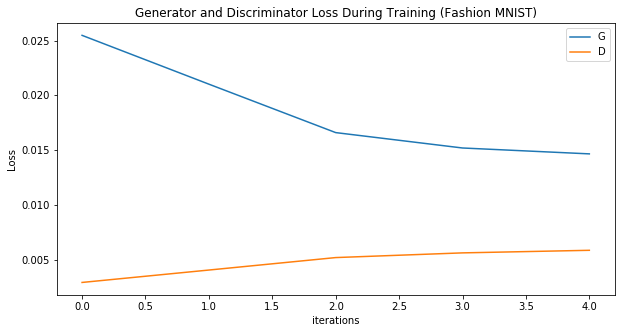

In [22]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training (Fashion MNIST)")
plt.plot(loss_G,label="G")
plt.plot(loss_D,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Save parameters

In [0]:
torch.save(generator.state_dict(), w_dir + 'DCGAN/generator_fashion_mnist.pth')
torch.save(discriminator.state_dict(), w_dir + 'DCGAN/discriminator_fashion_mnist.pth')

Generate and display fake images

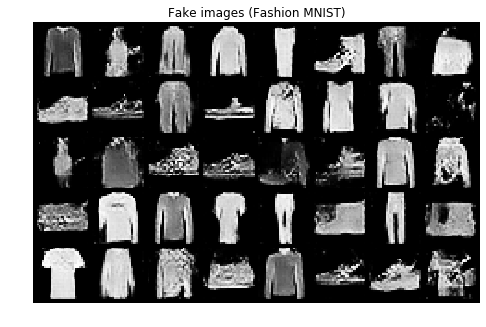

In [23]:
fake_imgs = generator(noise(128)).detach()
show_images(fake_imgs, (8, 8), 40, 'Fake images (Fashion MNIST)')